# Introduction to control theory. 

## TP4. Full State Linear Feedback Controller.
## Study load

Course grade breakdown:

    Labs - 40%
    
    Final project presentation 30%

    Final test 30%
    
File name for lab submission: yourname_labnumber.ipynb (example: elenavanneaux_TP4.ipynb)    

The completed notebook should be **submitted via the corresponding Moodle assignment before the beginning of the next session.**

## Prerequisites for practice
### Math
During the course, we will cover the following areas of mathematics:
    
    1. Linear Algebra

    2. Calculus

    3. Differential equations

    4. Dynamics (Mechanics and Physics)

### Python programming
In the labs we will use a Python programming language and the following libraries:

    1. NumPy https://numpy.org/doc/stable/

    2. SciPy https://docs.scipy.org/doc/scipy/

    3. Matplotlib https://matplotlib.org/stable/tutorials/index

    4. SymPy https://docs.sympy.org/latest/tutorials/intro-tutorial/intro.html

    5. Control System Library https://python-control.readthedocs.io/en/0.10.1/intro.html

### Jupyter Notebook Markdown Cells Documentation

Please check on Markdown cells documentation, to provide a fancy look for your notebooks!

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html


## EX. 1: Inverted Pendulum

The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.


Let us consider the system with the following system parameters
    
    (M)       mass of the cart                         0.5 kg
    
    (m)       mass of the pendulum                     0.2 kg
    
    (l)       length to pendulum center of mass        0.3 m
    
    (b)       coefficient of friction for cart         0.1 N/m/sec
    
    (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
    
    (F)       force applied to the cart
    
    (y)       cart position coordinate
    
    (theta)   angle between the pendulum and the vertical axis

The Inverted pendulum on the cart can be modeled as follows

$$
(M+m)\ddot{y} + b\dot{y} + ml\ddot{\theta}\cos\theta - ml\dot{\theta}^2\sin(\theta) = F
$$

$$
ml\cos(\theta)\ddot{y} + (I+ml^2)\ddot{\theta} - mgl\sin\theta = 0
$$

Let $y_1 = \dot{y}$ and $\theta_1 = \dot{\theta}$

The linearalised model have the following form

$$
\dot x = Ax + B(u+w)
$$

where state vector $x = (y,y_1,\theta,\theta_1)$, control vector $u$, disturbance $w$, and $F = u+w$. 

$$
\left[\begin{array}{c}\dot{y} \\ \dot{y1} \\ \dot{\theta} \\ \dot{\theta_1}\end{array}\right]=
\left[\begin{array}{cccc}0 & 1 & 0 & 0 \\
0 & \frac{-\left(I+m l^2\right) b}{I(M+m)+M m l^2}& \frac{-g m^2 l^2}{I(M+m)+M m l^2} & 0 \\
0 & 0 & 0 & 1 \\
0 & \frac{m l b}{I(M+m)+M m l^2} & \frac{m g l(M+m)}{I(M+m)+M m l^2} & 0\end{array}\right]
\left[\begin{array}{c}y \\ y_1\\ \theta \\ \theta_1\end{array}\right]+
\left[\begin{array}{c}0 \\ \frac{I+m l^2}{I(M+m)+M m l^2} \\ 0\\ \frac{-m l}{I(M+m)+M m l^2}\end{array}\right] (u+w)
$$

## TODO

1) Check on the code below implementing a PID controller ensuring tracking to the reference signal $\theta_{ref}$ = 0 rad, while supposing that the system is subject to a constant disturbance $w(t) = 0.1$. Is it a good controller for achieving the desirable behavior of the system?
2) Design a full-state linear feedback regulator u = -Kx that stabilize non distubed ($w(t) = 0$) system in (0,0,0,0).

    2.1 Is the system controllable? Why is it important? 

    2.2 Use control.place function from control library https://python-control.readthedocs.io/en/0.9.4/ to place eigenvalues lam_1 = -1, lam_2 = -2, lam_3 = -3, lam_4 = -4 in the closed-loop system. I.e. find a K, such that eig(A-BK) = [-1,-2,-3,-4]. Let $x_0 = (1,0,1,0)$ plot the corresponding trajectories of the closed-loop system. Is the system controlled by the regulator u =-Kx stable?

    2.3 Use the LQR regulator to stabilize the system around zero. Plot the trajectory of controlled system starting from $x_0 = (1,0,1,0).$ Analyze how the different choice of weight matrices Q and R affects the closed-loop system behavior. control.lqr from the control library https://python-control.readthedocs.io/en/0.9.4/ might be useful for you.
3)Analyse the response of the system controlled with an LQR regulator for different types of disturbances (like $w(t) = 0.1, w(t) = 10.0, w(t) = sin(t)$ etc...). What conclusion can you make?    

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import control as ctr

# x is a state vecot, t is a current time, A is a dynamic matrix, B is a control matrix, D is a disturbance matrix, 
# u_func(t) is a control input, w_func(t) is a disturbance input 
def StateSpace(x, t, A, B, D, u_func, w_func):
    w = w_func(t)
    u = u_func(t)
    return np.dot(A, x) + np.dot(B, u).flatten() + np.dot(D, w).flatten()

# OpenLoopInputOutputSystem with time-dependent w(t)
def OpenLoopInputOutputSystem(A, B, D, C, u_func, w_func, T, x0):
    # Solve the ODE system with odeint, passing the time-dependent w function
    solution = odeint(StateSpace, x0, T, args=(A, B, D, u_func, w_func))
    # Output calculation using C and the solution
    # return (C @ solution.T) 
    return (solution.T) 

def PID(A, B, D, C, Kp, Ki, Kd, r_func, w_func, T, x0):
    z0 = np.array([[0.0]])
    x_a =  np.block([[x0.reshape(-1,1)],[z0]])
    M = np.eye(x0.shape[0]) + Kd*B @ C
    A_a = np.block([[np.linalg.inv(M) @ (A - Kp * B @ C), -Ki * np.linalg.inv(M) @ B ], [C, np.array([0.0])]])
    B_a =  np.block([[Kp * np.linalg.inv(M) @ B ], [np.array([1.0])]])
    D_a = np.block([[np.linalg.inv(M) @ D],[np.array([[0.0]])]])
    C_a = np.block([C, np.array([[0.0]])])
    return OpenLoopInputOutputSystem(A_a, B_a, D_a, C_a, r_func, w_func, T, x_a.flatten()).T    

Text(0, 0.5, 'Position ')

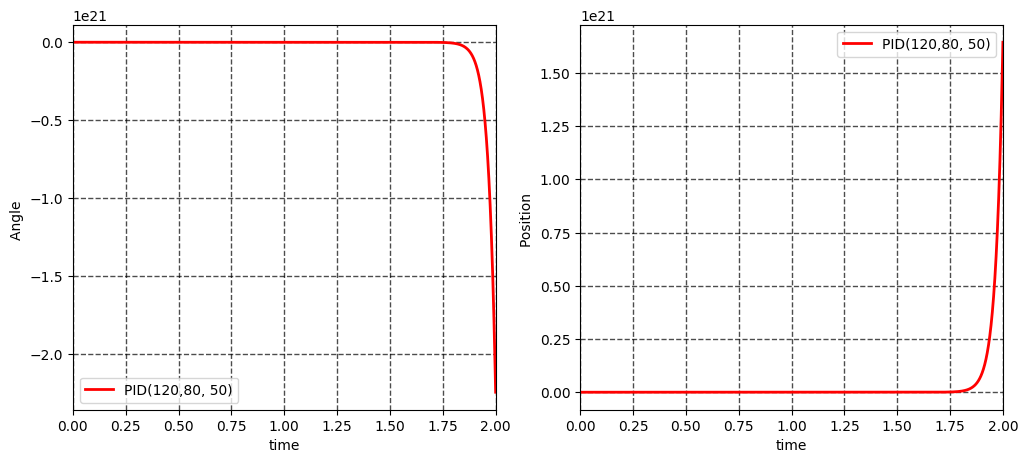

In [ ]:
import sympy as sp
from matplotlib.pyplot import *
# Answer to EX1 q1 using symbolic calculs
# Define symbolic variables
M, m, b, l, I, g, F = sp.symbols('M m b l I g F')
y, y1, theta, theta1, doty1, dottheta1 = sp.symbols('y y1 theta theta1 doty1 dottheta1')

# Define the differential equations of the system
eq1 = (M+m)*doty1 + b*y1 + m*l*dottheta1*sp.cos(theta) - m*l*theta1**2*sp.sin(theta) - F
eq2 = m*l*sp.cos(theta)*doty1 + (I+m*l**2)*dottheta1 - m*g*l*sp.sin(theta)

# Solve for the first derivative of theta1 (angular velocity)
dottheta1_sol = sp.solve(eq2, dottheta1)[0]

# Solve for the first derivative of y1 (linear velocity)
doty1_sol = sp.simplify(sp.solve(eq1.subs(dottheta1, dottheta1_sol), doty1)[0])
dottheta1_sol = sp.simplify(dottheta1_sol.subs(doty1,doty1_sol))

# Define the state-space representation of the system dynamics
f1 = y1
f2 = doty1_sol 
f3 = theta1
f4 = dottheta1_sol
f = sp.Matrix([f1, f2, f3, f4])

# Define state and control variables
variables_x = sp.Matrix([y,y1,theta,theta1])
variables_u = sp.Matrix([F])

# Compute the Jacobian matrices of the system
jacobian_A = sp.simplify(f.jacobian(variables_x).subs([(theta,0), (theta1,0)]))
jacobian_B = sp.simplify(f.jacobian(variables_u).subs([(theta,0), (theta1,0)]))

A = np.array(jacobian_A.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float)
B = np.array(jacobian_B.subs({M:2.5, m:0.2, b:0.1,l:0.7, I:0.006, g:9.81}).evalf()).astype(float).reshape(4,1)
C = np.array([[1,0,0,0],[0,0,1,0]]) 
D = B

x0 = np.array([0,
               0,
               0,
               0])  # initial state

MatC = np.array([[0,0,1,0]]) # Let us assume that we measure only theta

Kp= 120;
Ki = 80;
Kd = 50;

t0 = 0 # Initial time 
tf = 2 # Final time
T = np.linspace(t0, tf, 1000) 

def w_func(t):
       return 0.1# Disturbance input

def r_func(t):
       return 0.0# Disturbance input


solution = PID(A, B, D, MatC , Kp, Ki, Kd, r_func, w_func, T, x0)


figure(figsize=(12, 5))
y = solution[:,2]

subplot(1, 2, 1)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlabel('time')
xlim([t0, tf])
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Angle ')

y = solution[:,0]
subplot(1, 2, 2)
plot(T, y, linewidth=2.0, color = 'red')
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
xlabel('time')
plt.legend(['PID(120,80, 50)' ])
ylabel(r'Position ')

### Answer (TODO 1) — PID with constant disturbance

Based on the simulation results, this PID is not a good controller for the cart-pole in this setup (with $w(t)=0.1$ and $\theta_{ref}=0$).

- The plots show that the cart position $y$ diverges to extremely large values, and $\theta$ does not remain close to 0. This indicates that the closed-loop behavior is not stable (and/or quickly leaves the region where the linearized model is valid).

- The controller closes the loop only on $\theta$ (`MatC = [0,0,1,0]`). In that case, the pendulum can be kept near upright by continuously moving the cart, while the cart position is not explicitly regulated, which leads to position drift.

- With integral action ($K_i$) and a constant disturbance, the integrator can accumulate in a way that increases the required cart motion over time, which is consistent with the observed $y \to \infty$ behavior.

- Since the model is linearized around $\theta \approx 0$, once the states become large the linear approximation is no longer reliable, so further PID tuning based on this simulation is not very meaningful.

Conclusion: this PID (measuring only $\theta$ and not regulating $y$) does not achieve the desired objective (pendulum upright with bounded cart position) under constant disturbance. A more appropriate approach is full-state feedback (pole placement / LQR) as in TODO 2, and/or explicitly including cart position regulation.

## ANSWER TODO 2.1 — Controllability (w(t)=0)
Compute the controllability rank of $(A,B)$.

In [3]:
# EX1 — TODO 2.1: Controllability (w(t)=0)
import numpy as np
import control as ctr

# Parameters from the statement
M = 0.5   # cart mass [kg]
m = 0.2   # pendulum mass [kg]
l = 0.3   # COM length [m]
b = 0.1   # cart friction [N/(m/s)]
I = 0.006 # pendulum inertia [kg*m^2]
g = 9.81

def build_state_space(M, m, l, b, I, g):
    den = I*(M + m) + M*m*l**2
    A = np.array([
        [0, 1, 0, 0],
        [0, -((I + m*l**2)*b)/den, -(g*m**2*l**2)/den, 0],
        [0, 0, 0, 1],
        [0, (m*l*b)/den, (m*g*l*(M + m))/den, 0],
    ], dtype=float)
    B = np.array([[0],
                  [(I + m*l**2)/den],
                  [0],
                  [-(m*l)/den]], dtype=float)
    return A, B

A, B = build_state_space(M, m, l, b, I, g)

Wc = ctr.ctrb(A, B)
rank_Wc = np.linalg.matrix_rank(Wc)
n = A.shape[0]
print(f"rank(ctrb(A,B)) = {rank_Wc} (n={n})")

rank(ctrb(A,B)) = 4 (n=4)


### Answer
`rank(ctrb(A,B)) = 4` (full rank), so the linearized system is controllable. This matters because pole placement in 2.2 requires controllability to assign all closed-loop poles.

## ANSWER TODO 2.2 — Pole placement (w(t)=0)
Use `control.place` to assign the closed-loop eigenvalues to $-1,-2,-3,-4$, simulate from $x_0=(1,0,1,0)$, and plot the trajectories.

K (place) = [[ -0.5382263   -1.22130479 -14.78229052  -2.64852192]]
eig(A-BK) = [-4.+0.j -3.+0.j -2.+0.j -1.+0.j]


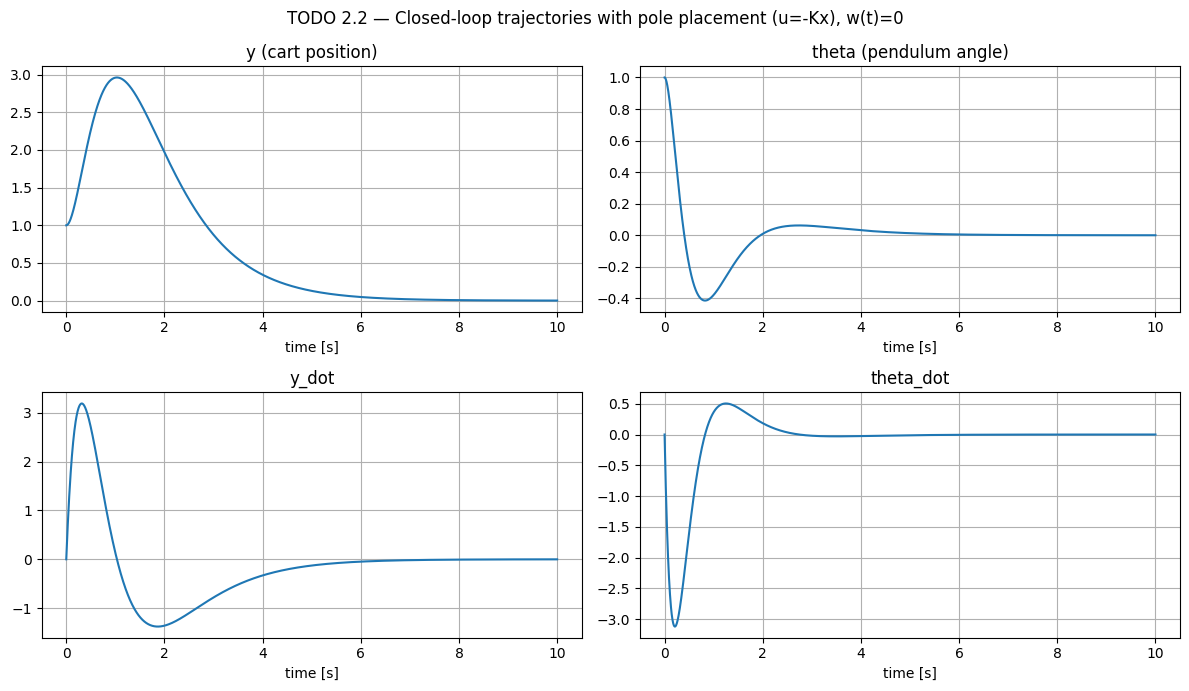

In [4]:
# EX1 — TODO 2.2: Pole placement (w(t)=0)
import numpy as np
import matplotlib.pyplot as plt
import control as ctr
from scipy.integrate import odeint

# Reuse A, B from TODO 2.1; rebuild if needed
try:
    A
    B
except NameError:
    def build_state_space(M, m, l, b, I, g):
        den = I*(M + m) + M*m*l**2
        A = np.array([[0, 1, 0, 0],
                      [0, -((I + m*l**2)*b)/den, -(g*m**2*l**2)/den, 0],
                      [0, 0, 0, 1],
                      [0, (m*l*b)/den, (m*g*l*(M + m))/den, 0]], dtype=float)
        B = np.array([[0],
                      [(I + m*l**2)/den],
                      [0],
                      [-(m*l)/den]], dtype=float)
        return A, B
    A, B = build_state_space(0.5, 0.2, 0.3, 0.1, 0.006, 9.81)

desired_poles = [-1, -2, -3, -4]
K_place = np.asarray(ctr.place(A, B, desired_poles))
Acl_place = A - B @ K_place
eig_place = np.linalg.eigvals(Acl_place)
print("K (place) =", K_place)
print("eig(A-BK) =", np.sort_complex(eig_place))

def closed_loop_rhs(x, t, Acl):
    return (Acl @ x).flatten()

t0, tf = 0.0, 10.0
T = np.linspace(t0, tf, 2000)
x0 = np.array([1.0, 0.0, 1.0, 0.0])
sol_place = odeint(closed_loop_rhs, x0, T, args=(Acl_place,))

fig = plt.figure(figsize=(12, 7))
ax1 = plt.subplot(2, 2, 1)
ax1.plot(T, sol_place[:, 0])
ax1.set_title('y (cart position)')
ax1.set_xlabel('time [s]')
ax1.grid(True)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(T, sol_place[:, 2])
ax2.set_title('theta (pendulum angle)')
ax2.set_xlabel('time [s]')
ax2.grid(True)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(T, sol_place[:, 1])
ax3.set_title('y_dot')
ax3.set_xlabel('time [s]')
ax3.grid(True)

ax4 = plt.subplot(2, 2, 4)
ax4.plot(T, sol_place[:, 3])
ax4.set_title('theta_dot')
ax4.set_xlabel('time [s]')
ax4.grid(True)

fig.suptitle('TODO 2.2 — Closed-loop trajectories with pole placement (u=-Kx), w(t)=0')
plt.tight_layout()

### Answer
The computed eigenvalues of $A-BK$ are exactly $-1,-2,-3,-4$, so the closed loop is asymptotically stable. For this parameter set,
$$K = \begin{bmatrix} -0.538226 & -1.221305 & -14.782291 & -2.648522 \end{bmatrix},$$
and the simulated trajectories from $x_0=(1,0,1,0)$ decay to 0 in the plots.

## ANSWER TODO 2.3 — LQR (w(t)=0) + disturbance tests
Compare the closed-loop behavior for different $Q$ and $R$ choices and then test perturbations $w(t)$ (e.g., 0.1, 10, $\sin t$). Conclude on performance vs effort and disturbance rejection.

eig(LQR #1) = [-8.3868991 +0.j         -3.75031475+0.j         -1.10200826-0.45083751j
 -1.10200826+0.45083751j]
eig(LQR #2) = [-7.59356799-3.84234591j -7.59356799+3.84234591j -1.06346674-0.90331497j
 -1.06346674+0.90331497j]
eig(LQR #3) = [-5.90165919-1.58259622j -5.90165919+1.58259622j -0.80557865-0.73852212j
 -0.80557865+0.73852212j]
x0=0, w=0: approx eq theta~0, y~0, max|u|=0
x0=0, w=0.1: approx eq theta~5.324e-07, y~-0.03162, max|u|=0.1429
x0=0, w=10: approx eq theta~5.322e-05, y~-3.162, max|u|=14.29
x0=0, w=sin(t): theta_mean=0.02198, theta_acRMS=0.004682, theta_p2p=0.01733, y_mean=-0.2245, y_acRMS=0.04778, y_p2p=0.1769, max|u|=1.065
x0=(1,0,1,0), w=0: approx eq theta~2.258e-05, y~0.0003964, max|u|=34.76
x0=(1,0,1,0), w=0.1: approx eq theta~2.312e-05, y~-0.03122, max|u|=34.76
x0=(1,0,1,0), w=10: approx eq theta~7.581e-05, y~-3.161, max|u|=34.76
x0=(1,0,1,0), w=sin(t): theta_mean=0.022, theta_acRMS=0.004708, theta_p2p=0.01744, y_mean=-0.2241, y_acRMS=0.04801, y_p2p=0.1777, max|u|=

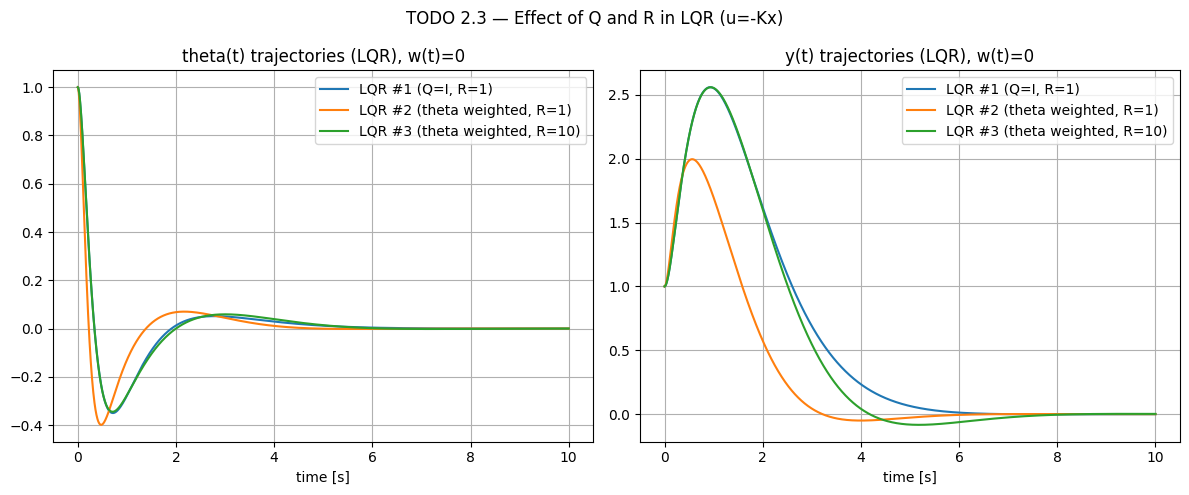

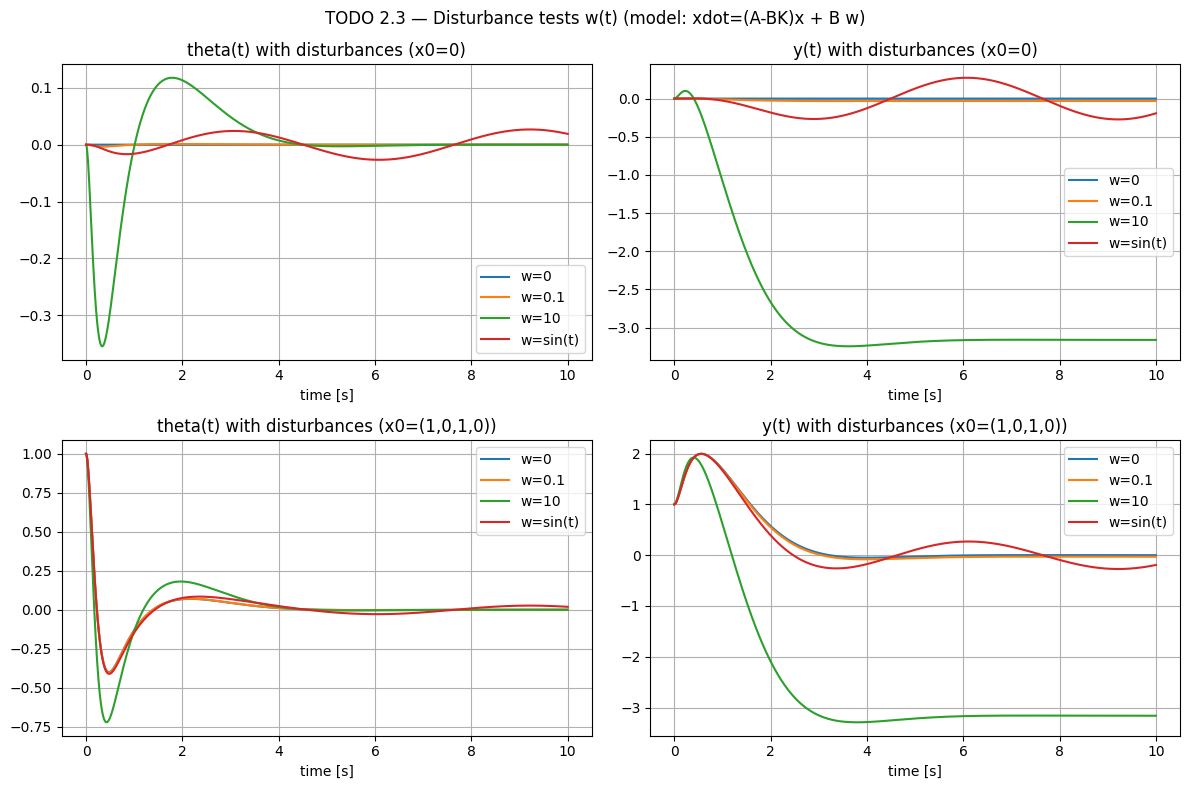

In [11]:
# EX1 — TODO 2.3: LQR and effect of Q, R + disturbance tests w(t)
import numpy as np
import matplotlib.pyplot as plt
import control as ctr
from scipy.integrate import odeint

# Build the EX1 (inverted pendulum) model locally to avoid clashes with EX2 variables
M = 0.5   # cart mass [kg]
m = 0.2   # pendulum mass [kg]
l = 0.3   # COM length [m]
b = 0.1   # cart friction [N/(m/s)]
I = 0.006 # pendulum inertia [kg*m^2]
g = 9.81

def build_state_space_ex1(M, m, l, b, I, g):
    den = I*(M + m) + M*m*l**2
    A = np.array([[0, 1, 0, 0],
                  [0, -((I + m*l**2)*b)/den, -(g*m**2*l**2)/den, 0],
                  [0, 0, 0, 1],
                  [0, (m*l*b)/den, (m*g*l*(M + m))/den, 0]], dtype=float)
    B = np.array([[0],
                  [(I + m*l**2)/den],
                  [0],
                  [-(m*l)/den]], dtype=float)
    return A, B

A_ex1, B_ex1 = build_state_space_ex1(M, m, l, b, I, g)

t0, tf = 0.0, 10.0
T = np.linspace(t0, tf, 2000)
x0 = np.array([1.0, 0.0, 1.0, 0.0])  # initial condition given in the statement

def simulate_lqr(Q, R, x0, T):
    K, S, E = ctr.lqr(A_ex1, B_ex1, Q, R)
    K = np.asarray(K)
    Acl = A_ex1 - B_ex1 @ K
    def rhs(x, t):
        return (Acl @ x).flatten()
    sol = odeint(rhs, x0, T)
    return K, np.asarray(E).flatten(), sol

# --- Part A: trade-off Q/R with w(t)=0 ---
Q1 = np.diag([1, 1, 1, 1])
R1 = np.array([[1.0]])

Q2 = np.diag([10, 1, 200, 1])
R2 = np.array([[1.0]])

Q3 = np.diag([10, 1, 200, 1])
R3 = np.array([[10.0]])

K1, E1, sol1 = simulate_lqr(Q1, R1, x0, T)
K2, E2, sol2 = simulate_lqr(Q2, R2, x0, T)
K3, E3, sol3 = simulate_lqr(Q3, R3, x0, T)

print("eig(LQR #1) =", np.sort_complex(E1))
print("eig(LQR #2) =", np.sort_complex(E2))
print("eig(LQR #3) =", np.sort_complex(E3))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(T, sol1[:, 2], label='LQR #1 (Q=I, R=1)')
plt.plot(T, sol2[:, 2], label='LQR #2 (theta weighted, R=1)')
plt.plot(T, sol3[:, 2], label='LQR #3 (theta weighted, R=10)')
plt.title('theta(t) trajectories (LQR), w(t)=0')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, sol1[:, 0], label='LQR #1 (Q=I, R=1)')
plt.plot(T, sol2[:, 0], label='LQR #2 (theta weighted, R=1)')
plt.plot(T, sol3[:, 0], label='LQR #3 (theta weighted, R=10)')
plt.title('y(t) trajectories (LQR), w(t)=0')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend()

plt.suptitle('TODO 2.3 — Effect of Q and R in LQR (u=-Kx)')
plt.tight_layout()

# --- Part B: disturbance tests w(t) ---
# Assumption: w(t) is an additive input disturbance in the same channel as u (cart force).
# Model: xdot = A x + B (u + w), with u = -Kx  =>  xdot = (A-BK)x + B w(t).
K_test = K2  # representative design (theta-weighted, moderate R)

def simulate_with_disturbance(K, w_fun, x0, T):
    Acl = A_ex1 - B_ex1 @ K
    def rhs(x, t):
        w = float(w_fun(t))
        return (Acl @ x + (B_ex1.flatten() * w)).flatten()
    sol = odeint(rhs, x0, T)
    # controller output u(t) = -Kx(t) (plant input is u+w)
    u = -(K @ sol.T).reshape(-1)
    return sol, u

def tail_metrics(signal, tail_fraction=0.2):
    n = len(signal)
    k0 = max(0, int((1.0 - tail_fraction) * n))
    seg = signal[k0:]
    mean = float(np.mean(seg))
    rms_total = float(np.sqrt(np.mean(seg**2)))
    rms_ac = float(np.sqrt(np.mean((seg - mean)**2)))
    p2p = float(np.max(seg) - np.min(seg))
    return mean, rms_total, rms_ac, p2p

disturbances = {
    'w=0': lambda t: 0.0,
    'w=0.1': lambda t: 0.1,
    'w=10': lambda t: 10.0,
    'w=sin(t)': lambda t: np.sin(t),
}

# Run both: near-equilibrium rejection (x0=0) and the statement initial condition (x0=(1,0,1,0))
initial_conditions = {
    'x0=0': np.zeros(4),
    'x0=(1,0,1,0)': x0,
}

results = {}  # results[(ic_label, w_label)] = (sol, u)
for ic_label, x0_ic in initial_conditions.items():
    for w_label, wfun in disturbances.items():
        sol_w, u_w = simulate_with_disturbance(K_test, wfun, x0_ic, T)
        results[(ic_label, w_label)] = (sol_w, u_w)

        theta = sol_w[:, 2]
        y = sol_w[:, 0]
        uabs_max = float(np.max(np.abs(u_w)))

        theta_mean, theta_rms_total, theta_rms_ac, theta_p2p = tail_metrics(theta)
        y_mean, y_rms_total, y_rms_ac, y_p2p = tail_metrics(y)

        if 'sin' in w_label:
            print(
                f"{ic_label}, {w_label}: "
                f"theta_mean={theta_mean:.4g}, theta_acRMS={theta_rms_ac:.4g}, theta_p2p={theta_p2p:.4g}, "
                f"y_mean={y_mean:.4g}, y_acRMS={y_rms_ac:.4g}, y_p2p={y_p2p:.4g}, max|u|={uabs_max:.4g}"
            )
        else:
            print(f"{ic_label}, {w_label}: approx eq theta~{theta_mean:.4g}, y~{y_mean:.4g}, max|u|={uabs_max:.4g}")

# Plot disturbance responses (2x2): rows = initial condition, cols = theta/y
plt.figure(figsize=(12, 8))
subplot_index = {('x0=0', 'theta'): 1, ('x0=0', 'y'): 2, ('x0=(1,0,1,0)', 'theta'): 3, ('x0=(1,0,1,0)', 'y'): 4}

for ic_label in initial_conditions.keys():
    # theta
    plt.subplot(2, 2, subplot_index[(ic_label, 'theta')])
    for w_label in disturbances.keys():
        sol_w, _ = results[(ic_label, w_label)]
        plt.plot(T, sol_w[:, 2], label=w_label)
    plt.title(f"theta(t) with disturbances ({ic_label})")
    plt.xlabel('time [s]')
    plt.grid(True)
    plt.legend()

    # y
    plt.subplot(2, 2, subplot_index[(ic_label, 'y')])
    for w_label in disturbances.keys():
        sol_w, _ = results[(ic_label, w_label)]
        plt.plot(T, sol_w[:, 0], label=w_label)
    plt.title(f"y(t) with disturbances ({ic_label})")
    plt.xlabel('time [s]')
    plt.grid(True)
    plt.legend()

plt.suptitle('TODO 2.3 — Disturbance tests w(t) (model: xdot=(A-BK)x + B w)')
plt.tight_layout()

### Answer
For $w(t)=0$, increasing the state weights in $Q$ typically makes the controller regulate the corresponding states more aggressively (faster convergence and smaller excursions), but it usually requires larger control effort. Increasing $R$ penalizes actuation more strongly, which generally reduces the control effort and makes the response more conservative/slower; the effect on overshoot/transients is not a strict rule and depends on the coupled dynamics and weightings.

When testing perturbations $w(t)$ modeled as an additive input disturbance in the same channel as $u$ (cart force), the LQR closed loop remains stable and trajectories stay bounded. For constant disturbances ($w(t)=0.1$ or $10$), the response generally converges to a nonzero equilibrium (steady-state offset), notably in the cart position $y(t)$, because pure state feedback without integral action does not guarantee zero steady-state error against constant disturbances. For sinusoidal $w(t)=\sin t$, there is no constant steady-state value; instead, the states exhibit bounded oscillations, which can be characterized by their RMS/peak-to-peak values over a time window.

The $w=10$ case produces much larger offsets and control effort; in practice this may push the system outside the validity range of the linearized model. If zero steady-state error under constant $w(t)$ is required, integral action (state augmentation) is needed.

## DC Motor Speed: System Modeling

A common actuator in control systems is the DC motor. It directly provides rotary motion and, coupled with wheels or drums and cables, can provide translational motion. The electric equivalent circuit of the armature and the free-body diagram of the rotor are shown in the following figure.

For this example, we will assume that the input of the system is the voltage source ($V$) applied to the motor's armature, while the output is the rotational speed of the shaft $\dot{\theta}$. The rotor and shaft are assumed to be rigid. We further assume a viscous friction model, that is, the friction torque is proportional to shaft angular velocity. We will assume that the magnetic field is constant and, therefore, that the motor torque is proportional (with constant $K_t$) to only the armature current. Let us remark that in SI units the motor torque and back emf constants are equal, that is, $K_t = K_e$;

The physical parameters for our example are:

    (J)   moment of inertia of the rotor     0.01 kg.m^2

    (b)     motor viscous friction constant    0.1 N.m.s

    (Ke)    electromotive force constant       0.01 V/rad/sec

    (Kt)    motor torque constant              0.01 N.m/Amp

    (R)     electric resistance                1 Ohm

    (L)     electric inductance                0.5 H
    

Let us suppose that the measured output of the system is the angular velocity of the rotor $\dot{\theta}$ and the current intensity $\dot{i}$. Then the state space model of the system is the following:
$$\dot x = Ax + Bu$$

$$ y = Cx$$

where state vector $x=(\dot{\theta}, i)$, control vector $u=V$, and state and control matrices are the following

$$ A = \begin{pmatrix} -\frac{b}{J}&\frac{K}{J}\\ -\frac{K}{L}&-\frac{R}{L}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{L} 
\end{pmatrix}$$


1. Design a LQR regulator that stabilizes the system in the zero.
2. Design a LQR regulator, that enables tracking a given constant reference for the angular velocity, while assuming that $i_{ref} = 0$. Use integral action to ensure robust tracking. Check the behavior of the closed loop system for $r = 1 rad/c$.

## Answer EX2 — Item 1: LQR regulator (stabilization at zero)
Design an LQR state-feedback law $u=-Kx$ that stabilizes the DC motor model at the origin.

LQR gain K:
[[0.74580694 0.65704766]]
Closed-loop eigenvalues eig(A-BK):
[-9.76569953 -3.54839578]


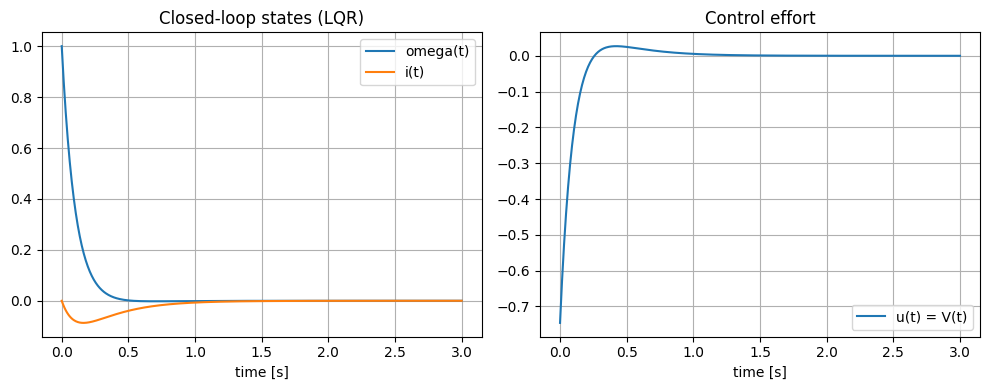

In [5]:
# EX2 — Item 1: LQR regulator (stabilization at zero)
import numpy as np
import matplotlib.pyplot as plt
import control as ctr

# Parameters (given)
J = 0.01   # kg.m^2
b = 0.1    # N.m.s
Ke = 0.01  # V/(rad/s)
Kt = 0.01  # N.m/A
R = 1.0    # Ohm
L = 0.5    # H

K = Ke  # in the statement, Kt = Ke = K

A = np.array([[-b / J,  Kt / J],
              [-K / L,  -R / L]], dtype=float)
B = np.array([[0.0],
              [1.0 / L]], dtype=float)

# LQR weights (tunable)
Q = np.diag([100.0, 1.0])   # penalize speed error more than armature current
R_lqr = np.array([[1.0]])   # penalize control effort (voltage)

K_lqr, S_lqr, E_lqr = ctr.lqr(A, B, Q, R_lqr)  # u = -K_lqr x
Acl = A - B @ K_lqr

print('LQR gain K:')
print(K_lqr)
print('Closed-loop eigenvalues eig(A-BK):')
print(np.linalg.eigvals(Acl))

# Simple closed-loop simulation from a nonzero initial condition
sys_cl = ctr.ss(Acl, np.zeros((2, 1)), np.eye(2), np.zeros((2, 1)))
t = np.linspace(0, 3.0, 600)
x0 = np.array([1.0, 0.0])  # omega(0)=1 rad/s, i(0)=0 A
t_out, x = ctr.initial_response(sys_cl, T=t, X0=x0)

omega = x[0, :]
i_arm = x[1, :]
u = -(K_lqr @ x).reshape(-1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t_out, omega, label='omega(t)')
plt.plot(t_out, i_arm, label='i(t)')
plt.title('Closed-loop states (LQR)')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t_out, u, label='u(t) = V(t)')
plt.title('Control effort')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend()

plt.tight_layout()

### Answer
Using $Q=\mathrm{diag}(100,1)$ and $R=1$, the LQR design returns a constant gain $K$ such that $A-BK$ has eigenvalues with negative real part, so the origin is asymptotically stable. The simulation from a nonzero initial condition shows both $\omega(t)$ and $i(t)$ converging to zero, with the corresponding voltage input $u(t)$ decaying as the state is regulated.

## Answer EX2 — Item 2: LQR tracking with integral action
Design a regulator that tracks a constant reference $r$ for the angular velocity ($\omega_{ref}=r$), while enforcing $i_{ref}=0$. Use integral action to obtain robust tracking (zero steady-state error for constant references / bounded constant disturbances).

Augmented LQR gain K_aug = [Kx  Ki]:
[[ 3.51087812  1.34752596 22.36067977]]
Closed-loop eigenvalues eig(A_aug - B_aug K_aug):
[-9.51417337 -1.17273799 -4.00814055]
Approx steady omega ≈ 1.0000 rad/s (target 1.0)
Approx steady current i ≈ 9.9998 A
Approx steady voltage u ≈ 10.0099 V
Approx steady speed error ≈ -2.470e-05 rad/s


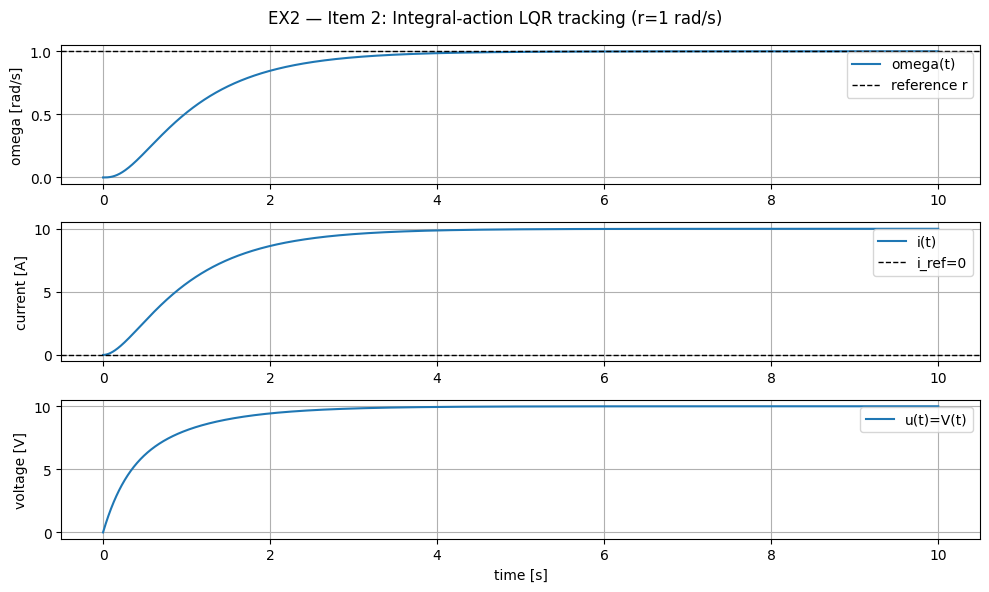

In [4]:
# EX2 — Item 2: LQR tracking with integral action (omega_ref=r, i_ref=0)
import numpy as np
import matplotlib.pyplot as plt
import control as ctr
from scipy.integrate import odeint

# Reuse A, B from Item 1 if they exist; otherwise rebuild from given parameters
try:
    A
    B
except NameError:
    J = 0.01
    b = 0.1
    Ke = 0.01
    Kt = 0.01
    Rm = 1.0
    L = 0.5
    K = Ke
    A = np.array([[-b / J,  Kt / J],
                  [-K / L,  -Rm / L]], dtype=float)
    B = np.array([[0.0],
                  [1.0 / L]], dtype=float)

# Track omega (state x1) to constant reference r; integrate speed error
C_r = np.array([[1.0, 0.0]])  # omega = C_r x

# Augmented state xa = [x; z], where z_dot = omega - r
A_aug = np.block([
    [A,                 np.zeros((2, 1))],
    [C_r,               np.zeros((1, 1))],
])
B_aug = np.vstack([B, [[0.0]]])

# LQR weights (tunable): penalize speed error, current, and integral error
Q_aug = np.diag([200.0, 1.0, 500.0])
R_lqr = np.array([[1.0]])

K_aug, S_aug, E_aug = ctr.lqr(A_aug, B_aug, Q_aug, R_lqr)
K_aug = np.asarray(K_aug)  # shape (1,3)
Acl_aug = A_aug - B_aug @ K_aug

print('Augmented LQR gain K_aug = [Kx  Ki]:')
print(K_aug)
print('Closed-loop eigenvalues eig(A_aug - B_aug K_aug):')
print(np.linalg.eigvals(Acl_aug))

# Closed-loop simulation for a constant reference r
r = 1.0  # rad/s (given)

def rhs_aug(xa, t, r_value):
    xa = np.asarray(xa).reshape(-1)
    u = float((-(K_aug @ xa.reshape(-1, 1))).item())
    x = xa[:2]
    omega = float((C_r @ x.reshape(-1, 1)).item())
    x_dot = (A @ x.reshape(-1, 1) + B * u).reshape(-1)
    z_dot = omega - float(r_value)
    return np.hstack([x_dot, z_dot])

# Use a longer horizon to show convergence to steady state
t = np.linspace(0.0, 10.0, 2500)
xa0 = np.array([0.0, 0.0, 0.0])  # start from rest
xa = odeint(rhs_aug, xa0, t, args=(r,))

omega = xa[:, 0]
i_arm = xa[:, 1]
z_int = xa[:, 2]
u = np.array([float((-(K_aug @ xa_k.reshape(-1, 1))).item()) for xa_k in xa])

# Report tail-average as a practical steady-state estimate
k0 = int(0.9 * len(t))
omega_ss = float(np.mean(omega[k0:]))
i_ss = float(np.mean(i_arm[k0:]))
u_ss = float(np.mean(u[k0:]))
print(f'Approx steady omega ≈ {omega_ss:.4f} rad/s (target {r})')
print(f'Approx steady current i ≈ {i_ss:.4f} A')
print(f'Approx steady voltage u ≈ {u_ss:.4f} V')
print(f'Approx steady speed error ≈ {omega_ss - r:.3e} rad/s')

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t, omega, label='omega(t)')
plt.axhline(r, color='k', linestyle='--', linewidth=1, label='reference r')
plt.ylabel('omega [rad/s]')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(t, i_arm, label='i(t)')
plt.axhline(0.0, color='k', linestyle='--', linewidth=1, label='i_ref=0')
plt.ylabel('current [A]')
plt.grid(True)
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(t, u, label='u(t)=V(t)')
plt.ylabel('voltage [V]')
plt.xlabel('time [s]')
plt.grid(True)
plt.legend()

plt.suptitle('EX2 — Item 2: Integral-action LQR tracking (r=1 rad/s)')
plt.tight_layout()

### Answer
To track a constant angular-velocity reference robustly, we augment the state with an integrator of the tracking error. For $r\neq 0$, define $z(t)=\int_0^t (\omega(\tau)-r)\,d\tau$, so $\dot z = \omega - r$, and design an LQR on the augmented dynamics $(A_{aug},B_{aug})$. The feedback law is
$$u(t) = -\begin{bmatrix}K_x & K_i\end{bmatrix}\begin{bmatrix}x(t)\\ z(t)\end{bmatrix}.$$
With $r=1\,\mathrm{rad/s}$, the simulation shows $\omega(t)$ converging to the reference and the steady-state speed error approaching (approximately) zero, which is the role of integral action.

Note that for this DC motor model with viscous friction ($b\neq 0$), maintaining a nonzero steady speed requires a nonzero steady current (torque) and, therefore, a nonzero steady input voltage. Hence, even if the reference for current is stated as $i_{ref}=0$, the equilibrium associated with $\omega\approx 1$ generally has $i\neq 0$ (otherwise the motor cannot balance friction).